In [1]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/tweets-hate-speech-detection/tweets_hate_speech_detection/" + splits["train"])

0 = No hate speach

1 = Hate speach

In [2]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [3]:
df['label'].value_counts()

,count
label,
0,29720
1,2242


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [5]:
df.isna().sum()

,0
label,0
tweet,0


Loading and exploring the dataset...
Training data shape: (31962, 2)
Test data shape: (17197, 2)
Training columns: ['label', 'tweet']
Test columns: ['label', 'tweet']

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB
None

Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB
None

Missing values in training data:
label    0
tweet    0
dtype: int64

Missing values in test data:
label    0
tweet    0
dtype: int64

Training label distribution:
label
0    29

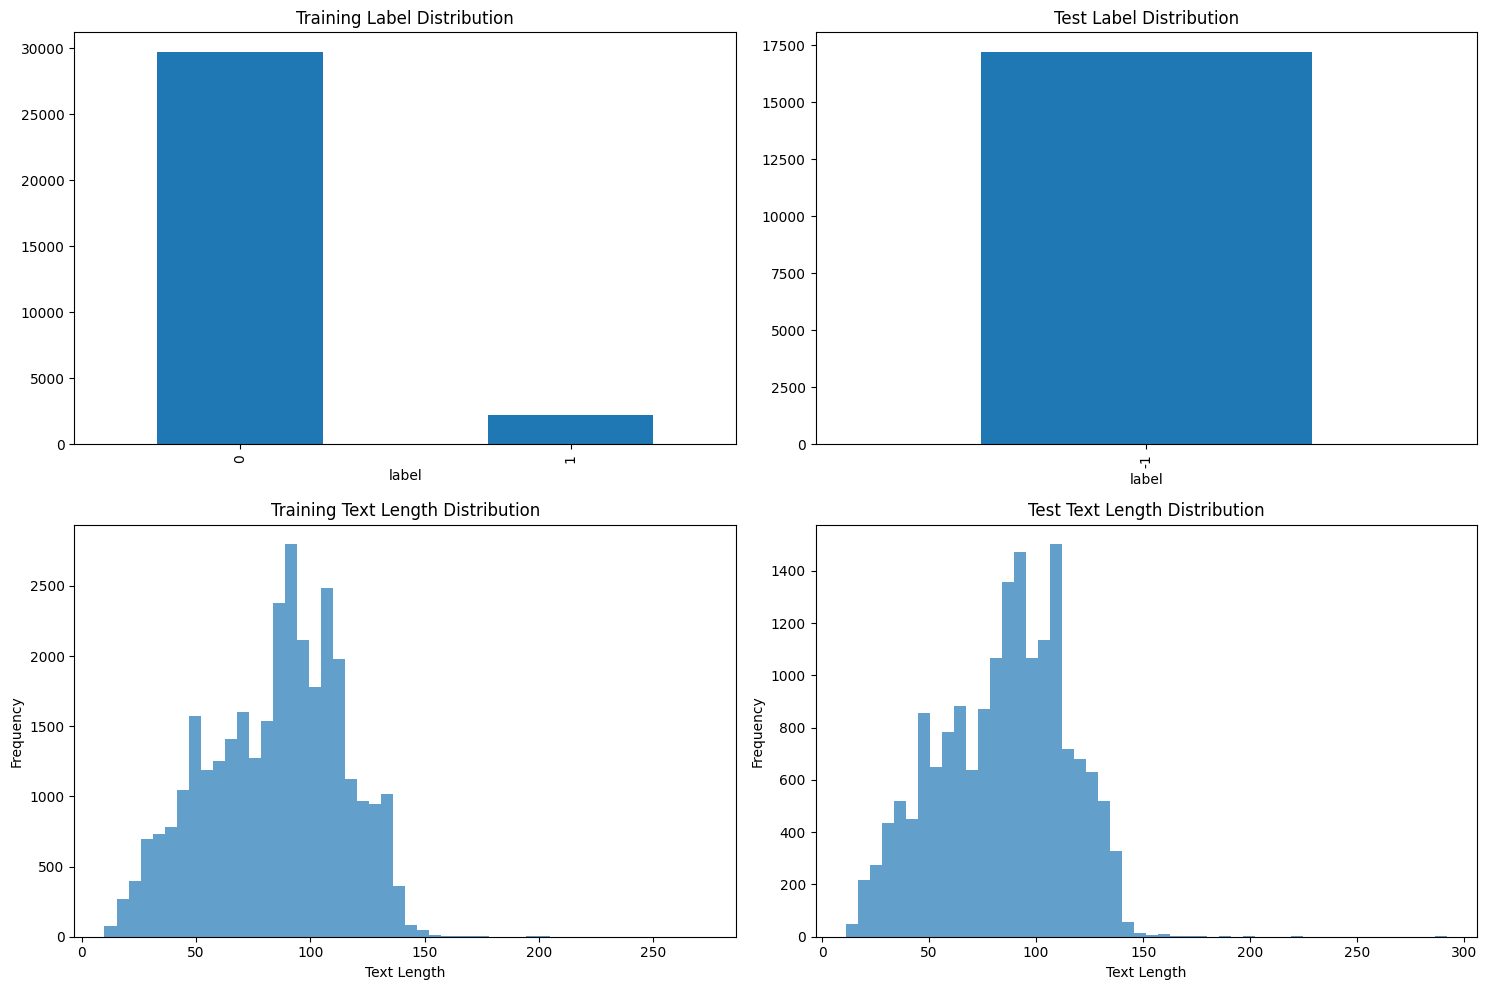

In [14]:
# Additional data exploration script to understand the dataset better
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def explore_dataset():
    """Explore the dataset to understand its structure and content."""

    print("Loading and exploring the dataset...")

    # Load data
    splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
    df_train = pd.read_parquet("hf://datasets/tweets-hate-speech-detection/tweets_hate_speech_detection/" + splits["train"])
    df_test = pd.read_parquet("hf://datasets/tweets-hate-speech-detection/tweets_hate_speech_detection/" + splits["test"])

    print(f"Training data shape: {df_train.shape}")
    print(f"Test data shape: {df_test.shape}")
    print(f"Training columns: {df_train.columns.tolist()}")
    print(f"Test columns: {df_test.columns.tolist()}")

    # Check data types
    print("\nTraining data info:")
    print(df_train.info())
    print("\nTest data info:")
    print(df_test.info())

    # Check for missing values
    print(f"\nMissing values in training data:")
    print(df_train.isnull().sum())
    print(f"\nMissing values in test data:")
    print(df_test.isnull().sum())

    # Examine label distributions
    print(f"\nTraining label distribution:")
    print(df_train['label'].value_counts().sort_index())
    print(f"\nTest label distribution:")
    print(df_test['label'].value_counts().sort_index())

    # Check unique labels
    train_labels = set(df_train['label'].unique())
    test_labels = set(df_test['label'].unique())
    print(f"\nUnique labels in training: {sorted(train_labels)}")
    print(f"Unique labels in test: {sorted(test_labels)}")
    print(f"Labels in test but not in train: {test_labels - train_labels}")
    print(f"Labels in train but not in test: {train_labels - test_labels}")

    # Sample data inspection
    print(f"\nSample training data:")
    print(df_train.head())

    print(f"\nSample test data:")
    print(df_test.head())

    # Text length analysis
    df_train['text_length'] = df_train['tweet'].astype(str).str.len()
    df_test['text_length'] = df_test['tweet'].astype(str).str.len()

    print(f"\nText length statistics (training):")
    print(df_train['text_length'].describe())
    print(f"\nText length statistics (test):")
    print(df_test['text_length'].describe())

    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Label distribution
    df_train['label'].value_counts().plot(kind='bar', ax=axes[0, 0], title='Training Label Distribution')
    df_test['label'].value_counts().plot(kind='bar', ax=axes[0, 1], title='Test Label Distribution')

    # Text length distribution
    axes[1, 0].hist(df_train['text_length'], bins=50, alpha=0.7, label='Training')
    axes[1, 0].set_title('Training Text Length Distribution')
    axes[1, 0].set_xlabel('Text Length')
    axes[1, 0].set_ylabel('Frequency')

    axes[1, 1].hist(df_test['text_length'], bins=50, alpha=0.7, label='Test')
    axes[1, 1].set_title('Test Text Length Distribution')
    axes[1, 1].set_xlabel('Text Length')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return df_train, df_test

if __name__ == "__main__":
    df_train, df_test = explore_dataset()

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

tf.random.set_seed(42)
np.random.seed(42)

class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, mask=None):
        q, k, v = inputs, inputs, inputs
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = self.create_feed_forward_network(d_model, dff)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def create_feed_forward_network(self, d_model, dff):
        return keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

    def call(self, inputs, training=None, mask=None):
        attn_output = self.attention(inputs, mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

class PositionalEncoding(layers.Layer):
    def __init__(self, max_seq_len, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.pos_encoding = self.create_positional_encoding(max_seq_len, d_model)

    def create_positional_encoding(self, max_seq_len, d_model):
        pos_encoding = np.zeros((max_seq_len, d_model))

        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pos_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / d_model)))
                if i + 1 < d_model:
                    pos_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))

        return tf.constant(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:seq_len, :]

def create_hate_speech_model(vocab_size, max_seq_len=100, d_model=128, num_heads=8,
                           num_layers=2, dff=256, num_classes=2, dropout_rate=0.1):
    inputs = layers.Input(shape=(max_seq_len,), name='input_tokens')
    embedding = layers.Embedding(vocab_size, d_model, mask_zero=True)(inputs)
    pos_encoding = PositionalEncoding(max_seq_len, d_model)(embedding)
    pos_encoding = layers.Dropout(dropout_rate)(pos_encoding)

    x = pos_encoding
    for i in range(num_layers):
        x = TransformerBlock(
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            dropout_rate=dropout_rate,
            name=f'transformer_block_{i}'
        )(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(dff, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(dff // 2, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='classification')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='hate_speech_classifier')
    return model

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

def create_tokenizer_and_vocab(texts, vocab_size=10000):
    tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=vocab_size,
        oov_token="<UNK>",
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    )
    tokenizer.fit_on_texts(texts)
    return tokenizer

def prepare_sequences(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=max_len, padding='post', truncating='post'
    )
    return padded_sequences

def create_custom_metrics():
    class F1Score(keras.metrics.Metric):
        def __init__(self, name='f1_score', **kwargs):
            super(F1Score, self).__init__(name=name, **kwargs)
            self.precision = keras.metrics.Precision()
            self.recall = keras.metrics.Recall()

        def update_state(self, y_true, y_pred, sample_weight=None):
            self.precision.update_state(y_true, y_pred, sample_weight)
            self.recall.update_state(y_true, y_pred, sample_weight)

        def result(self):
            precision = self.precision.result()
            recall = self.recall.result()
            return 2 * ((precision * recall) / (precision + recall + 1e-8))

        def reset_state(self):
            self.precision.reset_state()
            self.recall.reset_state()

    return F1Score()

def get_class_names(label_encoder):
    return [str(class_name) for class_name in label_encoder.classes_]

def main():
    print("Loading data...")
    splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
    df_train = pd.read_parquet("hf://datasets/tweets-hate-speech-detection/tweets_hate_speech_detection/" + splits["train"])
    df_test = pd.read_parquet("hf://datasets/tweets-hate-speech-detection/tweets_hate_speech_detection/" + splits["test"])

    print(f"Original training data shape: {df_train.shape}")
    print(f"Original test data shape: {df_test.shape}")

    test_has_labels = not (df_test['label'] == -1).all()

    if not test_has_labels:
        print("Test set appears to be unlabeled (all labels are -1).")
        print("Will use only training data and create train/validation/test splits.")

        df_all = df_train.copy()
        print(f"Training label distribution before cleaning:")
        print(df_all['label'].value_counts().sort_index())

        df_all = df_all[df_all['label'].isin([0, 1])].copy()
        print(f"After filtering valid labels: {df_all.shape}")

        print("Preprocessing texts...")
        df_all['processed_tweet'] = df_all['tweet'].apply(preprocess_text)
        df_all = df_all[df_all['processed_tweet'].str.len() > 0].copy()
        print(f"After removing empty tweets: {df_all.shape}")

        if len(df_all) == 0:
            print("Error: No valid data remaining after filtering!")
            return None, None, None, None

        train_data, temp_data = train_test_split(
            df_all, test_size=0.3, random_state=42, stratify=df_all['label']
        )
        val_data, test_data = train_test_split(
            temp_data, test_size=0.5, random_state=42, stratify=temp_data['label']
        )

        print(f"Final data splits:")
        print(f"Training: {train_data.shape}")
        print(f"Validation: {val_data.shape}")
        print(f"Test: {test_data.shape}")

        all_texts = df_all['processed_tweet'].tolist()

    else:
        print("Test set has valid labels. Using original train/test split.")
        train_data = df_train.copy()
        test_data = df_test.copy()

        train_data = train_data[train_data['label'].isin([0, 1])].copy()
        test_data = test_data[test_data['label'].isin([0, 1])].copy()

        train_data['processed_tweet'] = train_data['tweet'].apply(preprocess_text)
        test_data['processed_tweet'] = test_data['tweet'].apply(preprocess_text)

        train_data = train_data[train_data['processed_tweet'].str.len() > 0].copy()
        test_data = test_data[test_data['processed_tweet'].str.len() > 0].copy()

        train_data, val_data = train_test_split(
            train_data, test_size=0.2, random_state=42, stratify=train_data['label']
        )

        all_texts = pd.concat([train_data['processed_tweet'], val_data['processed_tweet'], test_data['processed_tweet']]).tolist()

    tokenizer = create_tokenizer_and_vocab(all_texts, vocab_size=10000)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Vocabulary size: {vocab_size}")

    max_len = 100
    X_train = prepare_sequences(train_data['processed_tweet'].tolist(), tokenizer, max_len)
    X_val = prepare_sequences(val_data['processed_tweet'].tolist(), tokenizer, max_len)
    X_test = prepare_sequences(test_data['processed_tweet'].tolist(), tokenizer, max_len)

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_data['label'].values)
    y_val = label_encoder.transform(val_data['label'].values)
    y_test = label_encoder.transform(test_data['label'].values)

    class_names = get_class_names(label_encoder)
    print(f"Label classes: {class_names}")
    print(f"Number of classes: {len(class_names)}")

    num_classes = len(label_encoder.classes_)
    y_train_cat = keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val_cat = keras.utils.to_categorical(y_val, num_classes=num_classes)
    y_test_cat = keras.utils.to_categorical(y_test, num_classes=num_classes)

    print(f"Final data shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train_cat.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val_cat.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test_cat.shape}")

    print("Creating model...")
    model = create_hate_speech_model(
        vocab_size=vocab_size,
        max_seq_len=max_len,
        d_model=128,
        num_heads=8,
        num_layers=2,
        dff=256,
        num_classes=num_classes,
        dropout_rate=0.1
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall', create_custom_metrics()]
    )

    model.summary()

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        keras.callbacks.ModelCheckpoint(
            'hate_speech_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False
        )
    ]

    print("Training model...")
    history = model.fit(
        X_train, y_train_cat,
        batch_size=32,
        epochs=20,
        validation_data=(X_val, y_val_cat),
        callbacks=callbacks,
        verbose=1
    )

    print("Evaluating on test set...")
    test_results = model.evaluate(X_test, y_test_cat, verbose=0)

    print(f"Test Results:")
    print(f"Loss: {test_results[0]:.4f}")
    print(f"Accuracy: {test_results[1]:.4f}")
    print(f"Precision: {test_results[2]:.4f}")
    print(f"Recall: {test_results[3]:.4f}")
    print(f"F1-Score: {test_results[4]:.4f}")

    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    print("Saving model and preprocessing components...")
    model.save('hate_speech_model.h5')

    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)

    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)

    model_config = {
        'max_len': max_len,
        'vocab_size': vocab_size,
        'class_names': class_names
    }

    with open('model_config.pkl', 'wb') as f:
        pickle.dump(model_config, f)

    print("Model saved as 'hate_speech_model.h5'")
    print("Tokenizer saved as 'tokenizer.pkl'")
    print("Label encoder saved as 'label_encoder.pkl'")
    print("Model config saved as 'model_config.pkl'")

    return model, tokenizer, label_encoder, history

if __name__ == "__main__":
    model, tokenizer, label_encoder, history = main()

Loading data...
Original training data shape: (31962, 2)
Original test data shape: (17197, 2)
Test set appears to be unlabeled (all labels are -1).
Will use only training data and create train/validation/test splits.
Training label distribution before cleaning:
label
0    29720
1     2242
Name: count, dtype: int64
After filtering valid labels: (31962, 2)
Preprocessing texts...
After removing empty tweets: (31935, 3)
Final data splits:
Training: (22354, 3)
Validation: (4790, 3)
Test: (4791, 3)
Vocabulary size: 29247
Label classes: ['0', '1']
Number of classes: 2
Final data shapes:
X_train: (22354, 100), y_train: (22354, 2)
X_val: (4790, 100), y_val: (4790, 2)
X_test: (4791, 100), y_test: (4791, 2)
Creating model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding_5' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "hate_speech_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_tokens (InputLayer)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 100, 128)       │     3,743,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_5           │ (None, 100, 128)       │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_0             │ (None, 100, 128)       │       132,480 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 100, 128)       │       132,480 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,074,754 (15.54 MB)

 Trainable params: 4,074,754 (15.54 MB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9237 - f1_score: 0.9237 - loss: 0.2718 - precision: 0.9237 - recall: 0.9237

699/699 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.9237 - f1_score: 0.9237 - loss: 0.2718 - precision: 0.9237 - recall: 0.9237 - val_accuracy: 0.9299 - val_f1_score: 0.9299 - val_loss: 0.2567 - val_precision: 0.9299 - val_recall: 0.9299 - learning_rate: 0.0010
Epoch 2/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9338 - f1_score: 0.9338 - loss: 0.2479 - precision: 0.9338 - recall: 0.9338 - val_accuracy: 0.9269 - val_f1_score: 0.9269 - val_loss: 0.2354 - val_precision: 0.9269 - val_recall: 0.9269 - learning_rate: 0.0010
Epoch 3/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9407 - f1_score: 0.9407 - loss: 0.1849 - precision: 0.9407 - recall: 0.9407 - val_accuracy: 0.9092 - val_f1_score: 0.9092 - val_loss: 0.2089 - val_precision: 0.9092 - val_recall: 0.9092 - learning_rate: 0.0010
Epoch 4/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9568 - f1_score: 0.9568 - loss: 0.1318 - precision: 0.9568 - recall: 0.9568 - val_accuracy: 0.9190 - val_f1_sc

699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9651 - f1_score: 0.9651 - loss: 0.0995 - precision: 0.9651 - recall: 0.9651 - val_accuracy: 0.9407 - val_f1_score: 0.9407 - val_loss: 0.1866 - val_precision: 0.9407 - val_recall: 0.9407 - learning_rate: 0.0010
Epoch 7/20
698/699 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9762 - f1_score: 0.9762 - loss: 0.0802 - precision: 0.9762 - recall: 0.9762

699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9762 - f1_score: 0.9762 - loss: 0.0802 - precision: 0.9762 - recall: 0.9762 - val_accuracy: 0.9443 - val_f1_score: 0.9443 - val_loss: 0.2674 - val_precision: 0.9443 - val_recall: 0.9443 - learning_rate: 0.0010
Epoch 8/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9771 - f1_score: 0.9771 - loss: 0.0725 - precision: 0.9771 - recall: 0.9771 - val_accuracy: 0.9225 - val_f1_score: 0.9225 - val_loss: 0.2281 - val_precision: 0.9225 - val_recall: 0.9225 - learning_rate: 0.0010
Epoch 9/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9812 - f1_score: 0.9812 - loss: 0.0611 - precision: 0.9812 - recall: 0.9812 - val_accuracy: 0.9365 - val_f1_score: 0.9365 - val_loss: 0.2770 - val_precision: 0.9365 - val_recall: 0.9365 - learning_rate: 0.0010
Epoch 10/20
695/699 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9849 - f1_score: 0.9849 - loss: 0.0497 - precision: 0.9849 - recall: 0.9849

699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9850 - f1_score: 0.9850 - loss: 0.0497 - precision: 0.9850 - recall: 0.9850 - val_accuracy: 0.9468 - val_f1_score: 0.9468 - val_loss: 0.2266 - val_precision: 0.9468 - val_recall: 0.9468 - learning_rate: 5.0000e-04
Epoch 11/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9876 - f1_score: 0.9876 - loss: 0.0417 - precision: 0.9876 - recall: 0.9876 - val_accuracy: 0.9441 - val_f1_score: 0.9441 - val_loss: 0.2317 - val_precision: 0.9441 - val_recall: 0.9441 - learning_rate: 5.0000e-04
Evaluating on test set...
Test Results:
Loss: 0.2045
Accuracy: 0.9322
Precision: 0.9322
Recall: 0.9322
F1-Score: 0.9322
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4455
           1       0.51      0.57      0.54       336

    accuracy                           0.93      4791
   macro avg       0.74      0.76      0.75      4791
weighted avg       0.94      0.93      0.93      4791

Saving model and preprocessing components...
Model saved as 'hate_speech_model.h5'
Tokenizer saved as 'tokenizer.pkl'
Label encoder saved as 'label_encoder.pkl'
Model config saved as 'model_config.pkl'


Fine tunning



In [20]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


Trial 20 Complete [00h 00m 38s]
val_f1_score: 0.9294999837875366

Best val_f1_score So Far: 0.9399999976158142
Total elapsed time: 00h 19m 12s

Best hyperparameters found:
d_model: 64
num_heads: 16
num_layers: 1
dff: 512
dropout_rate: 0.2
learning_rate: 0.005
dense_units_1: 256
dense_units_2: 64


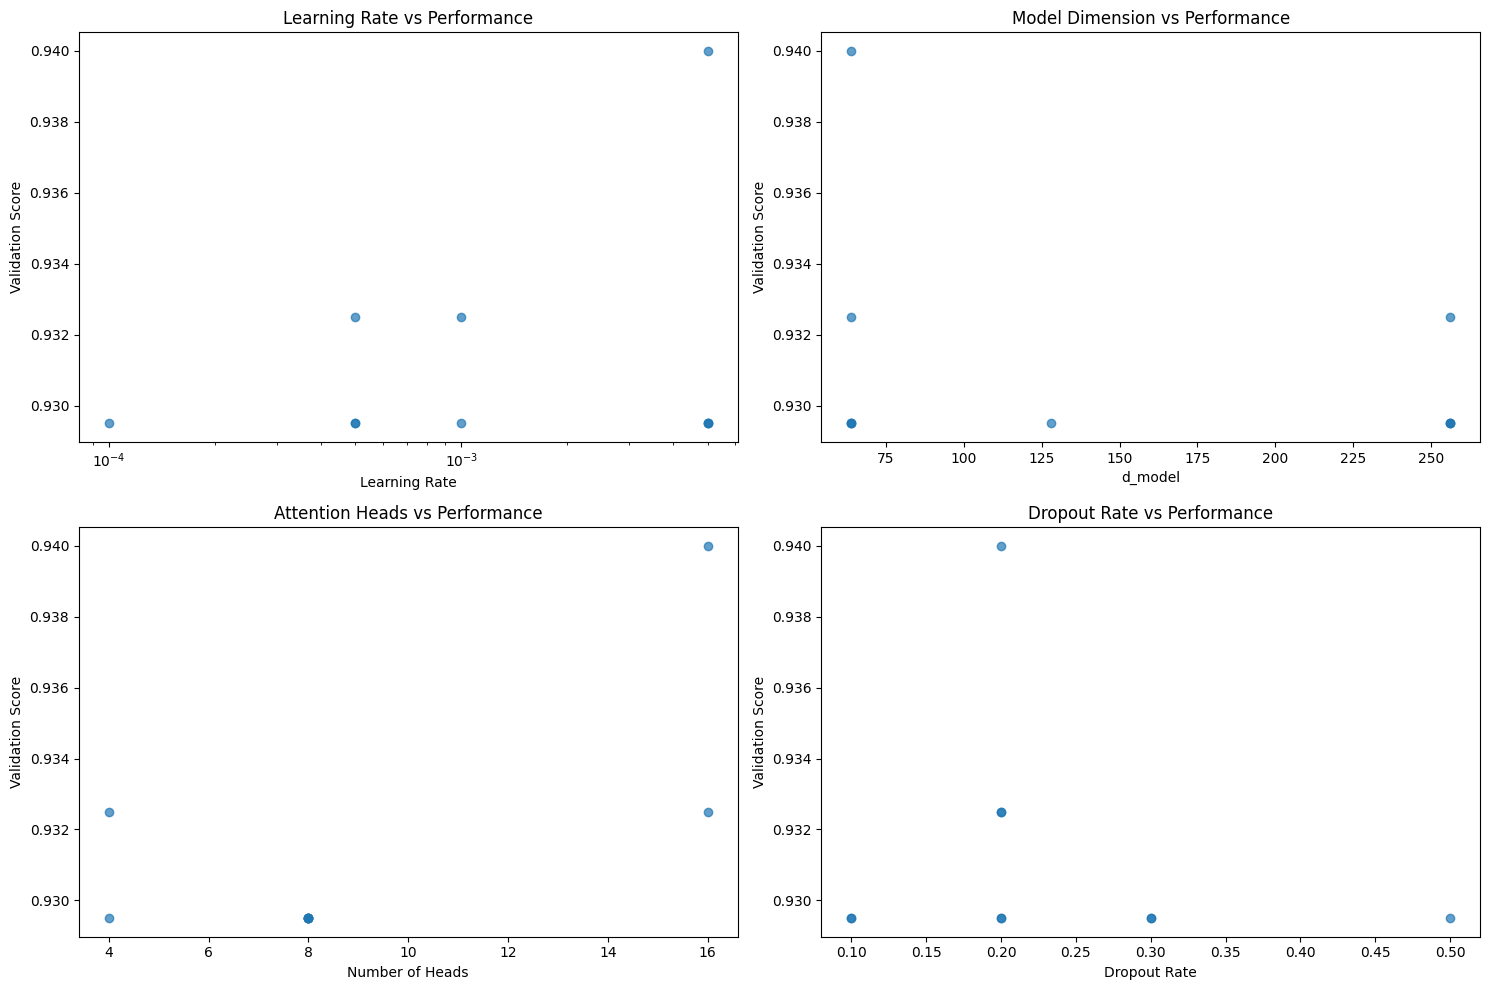


Training best model on full dataset...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Training final model with best hyperparameters...
Epoch 1/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9266 - f1_score: 0.9266 - loss: 0.2723 - precision: 0.9266 - recall: 0.9266

699/699 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.9266 - f1_score: 0.9266 - loss: 0.2723 - precision: 0.9266 - recall: 0.9266 - val_accuracy: 0.9299 - val_f1_score: 0.9299 - val_loss: 0.2467 - val_precision: 0.9299 - val_recall: 0.9299 - learning_rate: 0.0050
Epoch 2/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9339 - f1_score: 0.9339 - loss: 0.2225 - precision: 0.9339 - recall: 0.9339

699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9339 - f1_score: 0.9339 - loss: 0.2225 - precision: 0.9339 - recall: 0.9339 - val_accuracy: 0.9378 - val_f1_score: 0.9378 - val_loss: 0.1986 - val_precision: 0.9378 - val_recall: 0.9378 - learning_rate: 0.0050
Epoch 3/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9406 - f1_score: 0.9406 - loss: 0.1750 - precision: 0.9406 - recall: 0.9406 - val_accuracy: 0.9299 - val_f1_score: 0.9299 - val_loss: 0.1915 - val_precision: 0.9299 - val_recall: 0.9299 - learning_rate: 0.0050
Epoch 4/30
694/699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9514 - f1_score: 0.9514 - loss: 0.1406 - precision: 0.9514 - recall: 0.9514

699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9514 - f1_score: 0.9514 - loss: 0.1406 - precision: 0.9514 - recall: 0.9514 - val_accuracy: 0.9434 - val_f1_score: 0.9434 - val_loss: 0.1963 - val_precision: 0.9434 - val_recall: 0.9434 - learning_rate: 0.0050
Epoch 5/30
691/699 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9578 - f1_score: 0.9578 - loss: 0.1200 - precision: 0.9578 - recall: 0.9578

699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9578 - f1_score: 0.9578 - loss: 0.1200 - precision: 0.9578 - recall: 0.9578 - val_accuracy: 0.9449 - val_f1_score: 0.9449 - val_loss: 0.2225 - val_precision: 0.9449 - val_recall: 0.9449 - learning_rate: 0.0050
Epoch 6/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9645 - f1_score: 0.9645 - loss: 0.1075 - precision: 0.9645 - recall: 0.9645 - val_accuracy: 0.9361 - val_f1_score: 0.9361 - val_loss: 0.2652 - val_precision: 0.9361 - val_recall: 0.9361 - learning_rate: 0.0050
Epoch 7/30
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9701 - f1_score: 0.9701 - loss: 0.0872 - precision: 0.9701 - recall: 0.9701 - val_accuracy: 0.9449 - val_f1_score: 0.9449 - val_loss: 0.3480 - val_precision: 0.9449 - val_recall: 0.9449 - learning_rate: 0.0025
Epoch 8/30
692/699 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9741 - f1_score: 0.9741 - loss: 0.0830 - precision: 0.9741 - recall: 0.9741

699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9741 - f1_score: 0.9741 - loss: 0.0830 - precision: 0.9741 - recall: 0.9741 - val_accuracy: 0.9476 - val_f1_score: 0.9476 - val_loss: 0.3373 - val_precision: 0.9476 - val_recall: 0.9476 - learning_rate: 0.0025
Evaluating best model on test set...
Final Test Results:
Loss: 0.1960
Accuracy: 0.9278
Precision: 0.9278
Recall: 0.9278
F1-Score: 0.9278
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


Final Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4455
           1       0.49      0.55      0.52       336

    accuracy                           0.93      4791
   macro avg       0.73      0.75      0.74      4791
weighted avg       0.93      0.93      0.93      4791

Saving optimized model and preprocessing components...
Optimized model saved as 'optimized_hate_speech_model.h5'
Optimized tokenizer saved as 'optimized_tokenizer.pkl'
Optimized label encoder saved as 'optimized_label_encoder.pkl'
Optimized model config saved as 'optimized_model_config.pkl'


In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import keras_tuner as kt

tf.random.set_seed(42)
np.random.seed(42)

class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, mask=None):
        q, k, v = inputs, inputs, inputs
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = self.create_feed_forward_network(d_model, dff)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def create_feed_forward_network(self, d_model, dff):
        return keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

    def call(self, inputs, training=None, mask=None):
        attn_output = self.attention(inputs, mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

class PositionalEncoding(layers.Layer):
    def __init__(self, max_seq_len, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.pos_encoding = self.create_positional_encoding(max_seq_len, d_model)

    def create_positional_encoding(self, max_seq_len, d_model):
        pos_encoding = np.zeros((max_seq_len, d_model))

        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pos_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / d_model)))
                if i + 1 < d_model:
                    pos_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))

        return tf.constant(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:seq_len, :]

def create_custom_metrics():
    class F1Score(keras.metrics.Metric):
        def __init__(self, name='f1_score', **kwargs):
            super(F1Score, self).__init__(name=name, **kwargs)
            self.precision = keras.metrics.Precision()
            self.recall = keras.metrics.Recall()

        def update_state(self, y_true, y_pred, sample_weight=None):
            self.precision.update_state(y_true, y_pred, sample_weight)
            self.recall.update_state(y_true, y_pred, sample_weight)

        def result(self):
            precision = self.precision.result()
            recall = self.recall.result()
            return 2 * ((precision * recall) / (precision + recall + 1e-8))

        def reset_state(self):
            self.precision.reset_state()
            self.recall.reset_state()

    return F1Score()

class HyperModel(kt.HyperModel):
    def __init__(self, vocab_size, max_seq_len, num_classes):
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.num_classes = num_classes

    def build(self, hp):
        d_model = hp.Choice('d_model', values=[64, 128, 256])
        num_heads = hp.Choice('num_heads', values=[4, 8, 16])
        num_layers = hp.Int('num_layers', min_value=1, max_value=4, step=1)
        dff = hp.Choice('dff', values=[128, 256, 512])
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3, 5e-3])

        # Ensure d_model is divisible by num_heads
        while d_model % num_heads != 0:
            if d_model < num_heads:
                d_model = num_heads
            else:
                d_model += 1

        inputs = layers.Input(shape=(self.max_seq_len,), name='input_tokens')
        embedding = layers.Embedding(self.vocab_size, d_model, mask_zero=True)(inputs)
        pos_encoding = PositionalEncoding(self.max_seq_len, d_model)(embedding)
        pos_encoding = layers.Dropout(dropout_rate)(pos_encoding)

        x = pos_encoding
        for i in range(num_layers):
            x = TransformerBlock(
                d_model=d_model,
                num_heads=num_heads,
                dff=dff,
                dropout_rate=dropout_rate,
                name=f'transformer_block_{i}'
            )(x)

        x = layers.GlobalAveragePooling1D()(x)

        # Tunable classification head
        dense_units_1 = hp.Choice('dense_units_1', values=[128, 256, 512])
        dense_units_2 = hp.Choice('dense_units_2', values=[64, 128, 256])

        x = layers.Dense(dense_units_1, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(dense_units_2, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax', name='classification')(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name='hate_speech_classifier')

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy', 'precision', 'recall', create_custom_metrics()]
        )

        return model

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

def create_tokenizer_and_vocab(texts, vocab_size=10000):
    tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=vocab_size,
        oov_token="<UNK>",
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    )
    tokenizer.fit_on_texts(texts)
    return tokenizer

def prepare_sequences(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=max_len, padding='post', truncating='post'
    )
    return padded_sequences

def get_class_names(label_encoder):
    return [str(class_name) for class_name in label_encoder.classes_]

def create_stratified_sample(df, sample_size, target_column, random_state=42):
    """Create a stratified sample from the dataframe."""
    if len(df) <= sample_size:
        return df

    # Calculate the proportion to sample
    sample_fraction = sample_size / len(df)

    # Use train_test_split to get stratified sample
    sample_df, _ = train_test_split(
        df,
        test_size=1-sample_fraction,
        random_state=random_state,
        stratify=df[target_column]
    )

    return sample_df

def plot_tuning_results(tuner):
    """Plot hyperparameter tuning results."""
    trials = tuner.oracle.get_best_trials(num_trials=10)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Extract hyperparameters and scores
    learning_rates = []
    d_models = []
    num_heads_list = []
    dropout_rates = []
    scores = []

    for trial in trials:
        hp = trial.hyperparameters
        learning_rates.append(hp.get('learning_rate'))
        d_models.append(hp.get('d_model'))
        num_heads_list.append(hp.get('num_heads'))
        dropout_rates.append(hp.get('dropout_rate'))
        scores.append(trial.score if trial.score else 0)

    # Learning rate vs score
    axes[0, 0].scatter(learning_rates, scores, alpha=0.7)
    axes[0, 0].set_xlabel('Learning Rate')
    axes[0, 0].set_ylabel('Validation Score')
    axes[0, 0].set_title('Learning Rate vs Performance')
    axes[0, 0].set_xscale('log')

    # d_model vs score
    axes[0, 1].scatter(d_models, scores, alpha=0.7)
    axes[0, 1].set_xlabel('d_model')
    axes[0, 1].set_ylabel('Validation Score')
    axes[0, 1].set_title('Model Dimension vs Performance')

    # num_heads vs score
    axes[1, 0].scatter(num_heads_list, scores, alpha=0.7)
    axes[1, 0].set_xlabel('Number of Heads')
    axes[1, 0].set_ylabel('Validation Score')
    axes[1, 0].set_title('Attention Heads vs Performance')

    # dropout_rate vs score
    axes[1, 1].scatter(dropout_rates, scores, alpha=0.7)
    axes[1, 1].set_xlabel('Dropout Rate')
    axes[1, 1].set_ylabel('Validation Score')
    axes[1, 1].set_title('Dropout Rate vs Performance')

    plt.tight_layout()
    plt.show()

def main():
    print("Loading data...")
    splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
    df_train = pd.read_parquet("hf://datasets/tweets-hate-speech-detection/tweets_hate_speech_detection/" + splits["train"])
    df_test = pd.read_parquet("hf://datasets/tweets-hate-speech-detection/tweets_hate_speech_detection/" + splits["test"])

    print(f"Original training data shape: {df_train.shape}")
    print(f"Original test data shape: {df_test.shape}")

    test_has_labels = not (df_test['label'] == -1).all()

    if not test_has_labels:
        print("Test set appears to be unlabeled (all labels are -1).")
        print("Will use only training data and create train/validation/test splits.")

        df_all = df_train.copy()
        print(f"Training label distribution before cleaning:")
        print(df_all['label'].value_counts().sort_index())

        df_all = df_all[df_all['label'].isin([0, 1])].copy()
        print(f"After filtering valid labels: {df_all.shape}")

        print("Preprocessing texts...")
        df_all['processed_tweet'] = df_all['tweet'].apply(preprocess_text)
        df_all = df_all[df_all['processed_tweet'].str.len() > 0].copy()
        print(f"After removing empty tweets: {df_all.shape}")

        if len(df_all) == 0:
            print("Error: No valid data remaining after filtering!")
            return None, None, None, None, None

        # Use smaller subset for hyperparameter tuning to speed up the process
        if len(df_all) > 10000:
            print("Using subset of data for hyperparameter tuning...")
            df_sample = create_stratified_sample(df_all, 10000, 'label', random_state=42)
            print(f"Sample data shape: {df_sample.shape}")
            print(f"Sample label distribution:")
            print(df_sample['label'].value_counts().sort_index())
        else:
            df_sample = df_all

        train_data, temp_data = train_test_split(
            df_sample, test_size=0.4, random_state=42, stratify=df_sample['label']
        )
        val_data, test_data = train_test_split(
            temp_data, test_size=0.5, random_state=42, stratify=temp_data['label']
        )

        print(f"Tuning data splits:")
        print(f"Training: {train_data.shape}")
        print(f"Validation: {val_data.shape}")
        print(f"Test: {test_data.shape}")

        all_texts = df_sample['processed_tweet'].tolist()

    else:
        print("Test set has valid labels. Using original train/test split.")
        train_data = df_train.copy()
        test_data = df_test.copy()

        train_data = train_data[train_data['label'].isin([0, 1])].copy()
        test_data = test_data[test_data['label'].isin([0, 1])].copy()

        train_data['processed_tweet'] = train_data['tweet'].apply(preprocess_text)
        test_data['processed_tweet'] = test_data['tweet'].apply(preprocess_text)

        train_data = train_data[train_data['processed_tweet'].str.len() > 0].copy()
        test_data = test_data[test_data['processed_tweet'].str.len() > 0].copy()

        train_data, val_data = train_test_split(
            train_data, test_size=0.2, random_state=42, stratify=train_data['label']
        )

        all_texts = pd.concat([train_data['processed_tweet'], val_data['processed_tweet'], test_data['processed_tweet']]).tolist()

    tokenizer = create_tokenizer_and_vocab(all_texts, vocab_size=10000)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Vocabulary size: {vocab_size}")

    max_len = 100
    X_train = prepare_sequences(train_data['processed_tweet'].tolist(), tokenizer, max_len)
    X_val = prepare_sequences(val_data['processed_tweet'].tolist(), tokenizer, max_len)
    X_test = prepare_sequences(test_data['processed_tweet'].tolist(), tokenizer, max_len)

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_data['label'].values)
    y_val = label_encoder.transform(val_data['label'].values)
    y_test = label_encoder.transform(test_data['label'].values)

    class_names = get_class_names(label_encoder)
    print(f"Label classes: {class_names}")
    print(f"Number of classes: {len(class_names)}")

    num_classes = len(label_encoder.classes_)
    y_train_cat = keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val_cat = keras.utils.to_categorical(y_val, num_classes=num_classes)
    y_test_cat = keras.utils.to_categorical(y_test, num_classes=num_classes)

    print(f"Final data shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train_cat.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val_cat.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test_cat.shape}")

    # Initialize hyperparameter tuning
    print("Starting hyperparameter tuning...")

    hypermodel = HyperModel(
        vocab_size=vocab_size,
        max_seq_len=max_len,
        num_classes=num_classes
    )

    # Choose tuner strategy
    tuner = kt.RandomSearch(
        hypermodel,
        objective=kt.Objective('val_f1_score', direction='max'),
        max_trials=20,  # Adjust based on available time/resources
        directory='hyperparameter_tuning',
        project_name=f'hate_speech_tuning_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}'
    )

    # Alternative tuners you can use:
    # tuner = kt.BayesianOptimization(...)  # More efficient for larger search spaces
    # tuner = kt.Hyperband(...)  # Good for quick iterations

    print("Tuner search space summary:")
    tuner.search_space_summary()

    # Early stopping for hyperparameter search
    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    # Start hyperparameter search
    tuner.search(
        X_train, y_train_cat,
        epochs=10,  # Reduced epochs for faster tuning
        validation_data=(X_val, y_val_cat),
        callbacks=[stop_early],
        verbose=1
    )

    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print("\nBest hyperparameters found:")
    print(f"d_model: {best_hps.get('d_model')}")
    print(f"num_heads: {best_hps.get('num_heads')}")
    print(f"num_layers: {best_hps.get('num_layers')}")
    print(f"dff: {best_hps.get('dff')}")
    print(f"dropout_rate: {best_hps.get('dropout_rate')}")
    print(f"learning_rate: {best_hps.get('learning_rate')}")
    print(f"dense_units_1: {best_hps.get('dense_units_1')}")
    print(f"dense_units_2: {best_hps.get('dense_units_2')}")

    # Plot tuning results
    plot_tuning_results(tuner)

    # Build best model with full dataset
    print("\nTraining best model on full dataset...")

    # Reload full dataset for final training
    df_all_full = df_train.copy()
    df_all_full = df_all_full[df_all_full['label'].isin([0, 1])].copy()
    df_all_full['processed_tweet'] = df_all_full['tweet'].apply(preprocess_text)
    df_all_full = df_all_full[df_all_full['processed_tweet'].str.len() > 0].copy()

    train_full, temp_full = train_test_split(
        df_all_full, test_size=0.3, random_state=42, stratify=df_all_full['label']
    )
    val_full, test_full = train_test_split(
        temp_full, test_size=0.5, random_state=42, stratify=temp_full['label']
    )

    X_train_full = prepare_sequences(train_full['processed_tweet'].tolist(), tokenizer, max_len)
    X_val_full = prepare_sequences(val_full['processed_tweet'].tolist(), tokenizer, max_len)
    X_test_full = prepare_sequences(test_full['processed_tweet'].tolist(), tokenizer, max_len)

    y_train_full = label_encoder.transform(train_full['label'].values)
    y_val_full = label_encoder.transform(val_full['label'].values)
    y_test_full = label_encoder.transform(test_full['label'].values)

    y_train_full_cat = keras.utils.to_categorical(y_train_full, num_classes=num_classes)
    y_val_full_cat = keras.utils.to_categorical(y_val_full, num_classes=num_classes)
    y_test_full_cat = keras.utils.to_categorical(y_test_full, num_classes=num_classes)

    # Build and train the best model
    best_model = tuner.hypermodel.build(best_hps)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        keras.callbacks.ModelCheckpoint(
            'best_tuned_hate_speech_model.h5',
            monitor='val_f1_score',
            save_best_only=True,
            save_weights_only=False,
            mode='max'
        )
    ]

    print("Training final model with best hyperparameters...")
    history = best_model.fit(
        X_train_full, y_train_full_cat,
        batch_size=32,
        epochs=30,
        validation_data=(X_val_full, y_val_full_cat),
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate final model
    print("Evaluating best model on test set...")
    test_results = best_model.evaluate(X_test_full, y_test_full_cat, verbose=0)

    print(f"Final Test Results:")
    print(f"Loss: {test_results[0]:.4f}")
    print(f"Accuracy: {test_results[1]:.4f}")
    print(f"Precision: {test_results[2]:.4f}")
    print(f"Recall: {test_results[3]:.4f}")
    print(f"F1-Score: {test_results[4]:.4f}")

    y_pred_proba = best_model.predict(X_test_full)
    y_pred = np.argmax(y_pred_proba, axis=1)

    print("Final Classification Report:")
    print(classification_report(y_test_full, y_pred, target_names=class_names))

    # Save best model and configurations
    print("Saving optimized model and preprocessing components...")
    best_model.save('optimized_hate_speech_model.h5')

    with open('optimized_tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)

    with open('optimized_label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)

    best_config = {
        'max_len': max_len,
        'vocab_size': vocab_size,
        'class_names': class_names,
        'best_hyperparameters': {
            'd_model': best_hps.get('d_model'),
            'num_heads': best_hps.get('num_heads'),
            'num_layers': best_hps.get('num_layers'),
            'dff': best_hps.get('dff'),
            'dropout_rate': best_hps.get('dropout_rate'),
            'learning_rate': best_hps.get('learning_rate'),
            'dense_units_1': best_hps.get('dense_units_1'),
            'dense_units_2': best_hps.get('dense_units_2')
        }
    }

    with open('optimized_model_config.pkl', 'wb') as f:
        pickle.dump(best_config, f)

    print("Optimized model saved as 'optimized_hate_speech_model.h5'")
    print("Optimized tokenizer saved as 'optimized_tokenizer.pkl'")
    print("Optimized label encoder saved as 'optimized_label_encoder.pkl'")
    print("Optimized model config saved as 'optimized_model_config.pkl'")

    return best_model, tokenizer, label_encoder, history, best_hps

if __name__ == "__main__":
    model, tokenizer, label_encoder, history, best_hps = main()